# Bonus A | RLHF 全景：PPO 与 Reward Model

---

**目标：** 深入理解 RLHF 的完整流程

**这是 ChatGPT 的起源技术！**

---

## 本章内容

1. **RLHF 三阶段**：SFT → Reward Model → PPO
2. **Reward Model**：训练一个打分模型
3. **PPO 基础**：策略梯度优化
4. **为什么 DPO 更流行**：RLHF 的问题

---

## 🎓 前置知识：深入 RLHF

### 什么是 RLHF？

**RLHF (Reinforcement Learning from Human Feedback)**

= 用人类反馈来训练模型

这是 ChatGPT 成功的关键技术之一！

### RLHF 的三个阶段

```
阶段1: SFT (监督微调)
       用对话数据教模型"怎么对话"
           ↓
阶段2: 训练 Reward Model
       用人类偏好数据训练一个"评分器"
           ↓
阶段3: PPO 强化学习
       用 Reward Model 的分数来优化模型
```

### 为什么需要强化学习？

SFT 的问题：
- 只能模仿训练数据
- 不能超越训练数据的质量

强化学习的优势：
- 可以探索新的回答方式
- 可以根据反馈持续改进

### 与 DPO 的关系

- **RLHF**：完整方案，需要训练 Reward Model + PPO
- **DPO**：简化方案，直接用偏好数据优化

本章深入讲解 RLHF 的数学原理，帮助你更好理解 DPO 为什么有效。

### 本章目标

- 理解 Reward Model 的训练方法
- 学习 PPO 算法的基本原理
- 了解 RLHF 的工程挑战
- 对比 RLHF 和 DPO 的优缺点

## 0. 环境准备

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)
print("环境准备完成！")

环境准备完成！


---

## 1. RLHF 三阶段总览

### 完整流程

```
阶段 1: SFT（Supervised Fine-Tuning）
        ↓ 得到初始策略模型
阶段 2: 奖励模型训练（Reward Model Training）
        ↓ 训练打分模型
阶段 3: PPO（Proximal Policy Optimization）
        ↓ 用强化学习优化策略
最终: 对齐后模型（Aligned Model）
```


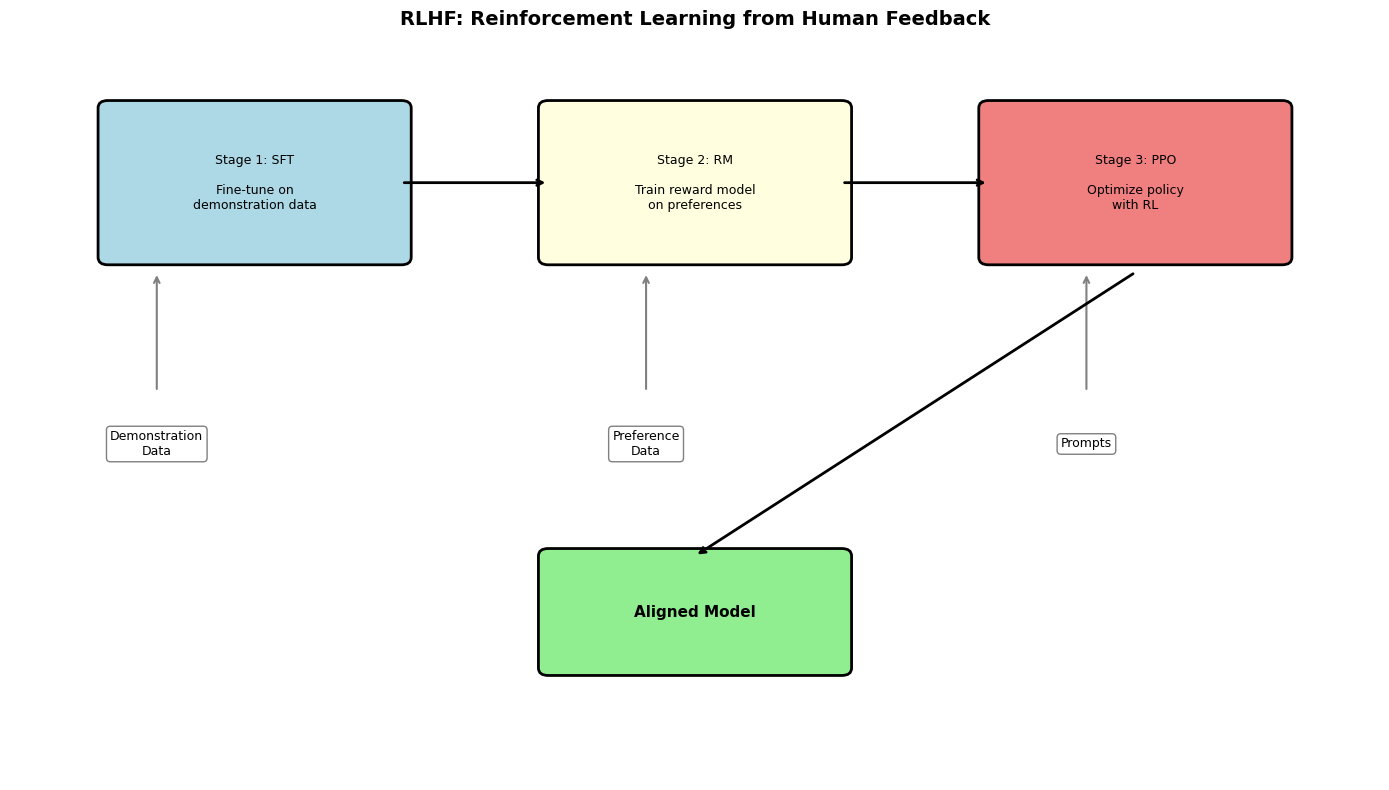

In [2]:
# 可视化 RLHF 流程
fig, ax = plt.subplots(figsize=(14, 8))
ax.set_xlim(0, 14)
ax.set_ylim(0, 10)
ax.axis('off')

import matplotlib.patches as patches

# 三个阶段
stages = [
    (1, 7, 3, 2, "Stage 1: SFT\n\nFine-tune on\ndemonstration data", "lightblue"),
    (5.5, 7, 3, 2, "Stage 2: RM\n\nTrain reward model\non preferences", "lightyellow"),
    (10, 7, 3, 2, "Stage 3: PPO\n\nOptimize policy\nwith RL", "lightcoral"),
]

for x, y, w, h, text, color in stages:
    rect = patches.FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.1",
                                   facecolor=color, edgecolor='black', linewidth=2)
    ax.add_patch(rect)
    ax.text(x + w/2, y + h/2, text, ha='center', va='center', fontsize=9)

# 箭头
ax.annotate('', xy=(5.5, 8), xytext=(4, 8),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))
ax.annotate('', xy=(10, 8), xytext=(8.5, 8),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))

# 输入数据
inputs = [
    (1.5, 4.5, "Demonstration\nData"),
    (6.5, 4.5, "Preference\nData"),
    (11, 4.5, "Prompts"),
]

for x, y, text in inputs:
    ax.text(x, y, text, ha='center', va='center', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray'))
    ax.annotate('', xy=(x, 6.8), xytext=(x, 5.2),
                arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

# 最终模型
rect = patches.FancyBboxPatch((5.5, 1.5), 3, 1.5, boxstyle="round,pad=0.1",
                               facecolor='lightgreen', edgecolor='black', linewidth=2)
ax.add_patch(rect)
ax.text(7, 2.25, "Aligned Model", ha='center', va='center', fontsize=11, fontweight='bold')
ax.annotate('', xy=(7, 3), xytext=(11.5, 6.8),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))

plt.title('RLHF: Reinforcement Learning from Human Feedback', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 2. Reward Model：训练打分模型

### 什么是 Reward Model？

给定 (prompt, response)，输出一个分数，表示回答的"好坏"。

### 训练数据

```
Prompt: "如何学习 Python?"
Response A: "阅读文档" (评分: 3)
Response B: "从基础开始，每天练习..." (评分: 8)
```

### 训练目标

让 RM(A) < RM(B) 当 B 比 A 更好时


In [3]:
class RewardModel(nn.Module):
    """
    简单的 Reward Model
    """
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256):
        super().__init__()
        
        # 简化：用一个小型 Transformer
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=4, batch_first=True),
            num_layers=2
        )
        
        # 输出一个标量分数
        self.score_head = nn.Linear(embed_dim, 1)
    
    def forward(self, input_ids):
        # input_ids: [batch, seq_len]
        x = self.embedding(input_ids)  # [batch, seq_len, embed_dim]
        x = self.transformer(x)         # [batch, seq_len, embed_dim]
        
        # 取最后一个 token 的表示
        x = x[:, -1, :]                 # [batch, embed_dim]
        
        # 输出分数
        score = self.score_head(x)      # [batch, 1]
        return score.squeeze(-1)

# 创建模型
rm = RewardModel(vocab_size=1000)
print(f"Reward Model 参数量: {sum(p.numel() for p in rm.parameters()):,}")

# 测试
input_ids = torch.randint(0, 1000, (2, 50))
scores = rm(input_ids)
print(f"输入形状: {input_ids.shape}")
print(f"输出分数: {scores}")

Reward Model 参数量: 1,314,177
输入形状: torch.Size([2, 50])
输出分数: tensor([-0.8245,  0.0344], grad_fn=<SqueezeBackward1>)


模拟 Reward Model 训练...


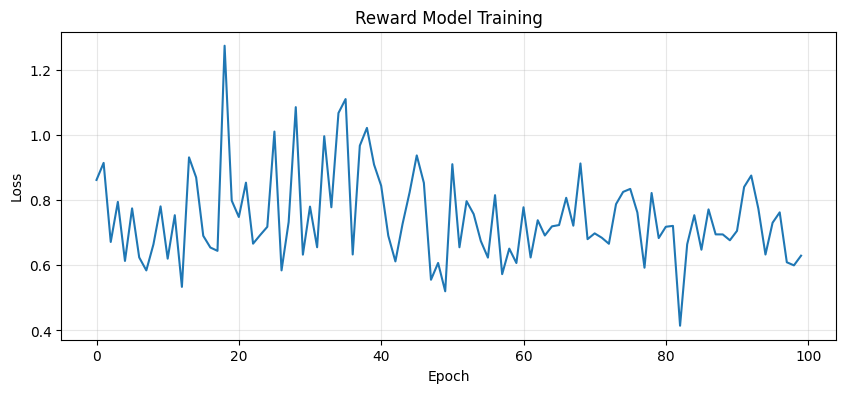

In [4]:
def reward_model_loss(scores_chosen, scores_rejected):
    """
    Reward Model 的损失函数
    
    目标：让 chosen 的分数高于 rejected
    """
    # Bradley-Terry loss
    loss = -F.logsigmoid(scores_chosen - scores_rejected).mean()
    return loss

# 模拟训练
rm = RewardModel(vocab_size=1000)
optimizer = torch.optim.Adam(rm.parameters(), lr=1e-4)

print("模拟 Reward Model 训练...")
losses = []

for epoch in range(100):
    # 模拟数据
    chosen = torch.randint(0, 1000, (8, 50))
    rejected = torch.randint(0, 1000, (8, 50))
    
    scores_chosen = rm(chosen)
    scores_rejected = rm(rejected)
    
    loss = reward_model_loss(scores_chosen, scores_rejected)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Reward Model Training')
plt.grid(True, alpha=0.3)
plt.show()

---

## 3. PPO：策略梯度优化

### PPO 的核心思想

1. **策略梯度**：增加高奖励动作的概率
2. **Clipping**：限制更新幅度，保持稳定
3. **KL 惩罚**：不要偏离原始模型太远

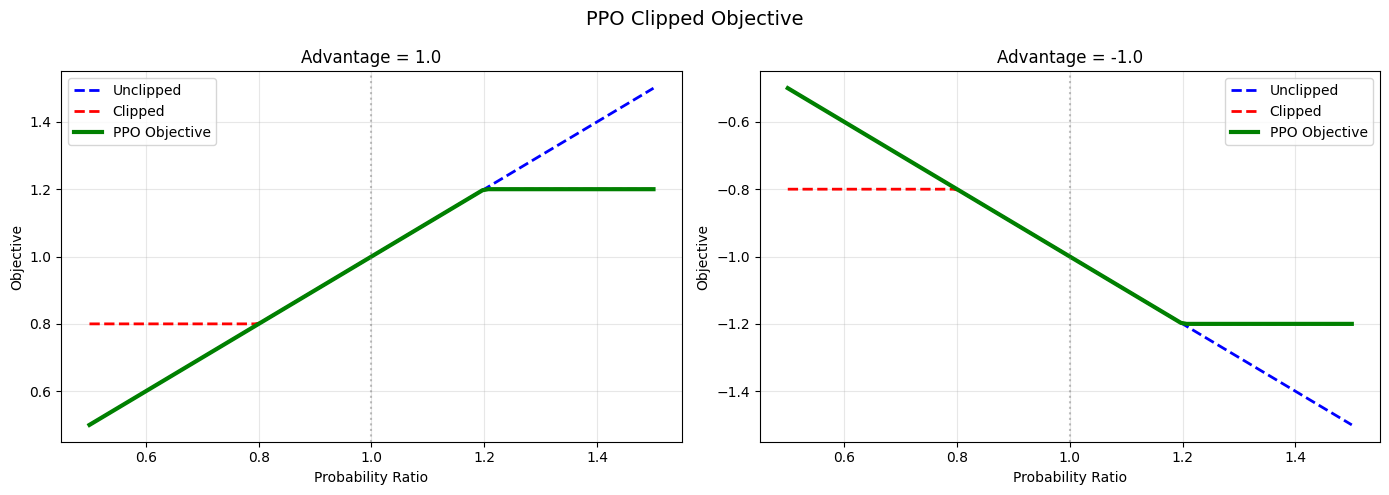

PPO 通过 clipping 限制策略更新幅度，保持训练稳定


In [5]:
def ppo_loss(log_probs, old_log_probs, advantages, clip_epsilon=0.2):
    """
    PPO Clipped Loss
    
    参数:
        log_probs: 当前策略的 log 概率
        old_log_probs: 旧策略的 log 概率
        advantages: 优势函数值
        clip_epsilon: 裁剪范围
    """
    # 计算概率比
    ratio = torch.exp(log_probs - old_log_probs)
    
    # Clipped ratio
    clipped_ratio = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon)
    
    # PPO loss = min(ratio * A, clipped_ratio * A)
    loss = -torch.min(ratio * advantages, clipped_ratio * advantages).mean()
    
    return loss

# 可视化 clipping
ratios = np.linspace(0.5, 1.5, 100)
advantages = np.array([1.0, -1.0])  # 正向和负向

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, adv in enumerate(advantages):
    unclipped = ratios * adv
    clipped = np.clip(ratios, 0.8, 1.2) * adv
    objective = np.minimum(unclipped, clipped) if adv > 0 else np.maximum(unclipped, clipped)
    
    axes[i].plot(ratios, unclipped, 'b--', label='Unclipped', linewidth=2)
    axes[i].plot(ratios, clipped, 'r--', label='Clipped', linewidth=2)
    axes[i].plot(ratios, objective, 'g-', label='PPO Objective', linewidth=3)
    axes[i].axvline(x=1, color='gray', linestyle=':', alpha=0.5)
    axes[i].set_xlabel('Probability Ratio')
    axes[i].set_ylabel('Objective')
    axes[i].set_title(f'Advantage = {adv}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.suptitle('PPO Clipped Objective', fontsize=14)
plt.tight_layout()
plt.show()

print("PPO 通过 clipping 限制策略更新幅度，保持训练稳定")

---

## 4. RLHF 的问题

### 为什么 RLHF 难以训练？

1. **Reward Hacking**：模型找到"作弊"方式获得高分
2. **不稳定**：PPO 超参数敏感
3. **复杂**：需要同时维护多个模型
4. **成本高**：需要大量采样和计算

**注：** 下方对比图为示意/模拟数据，用于说明复杂度与成本差异。

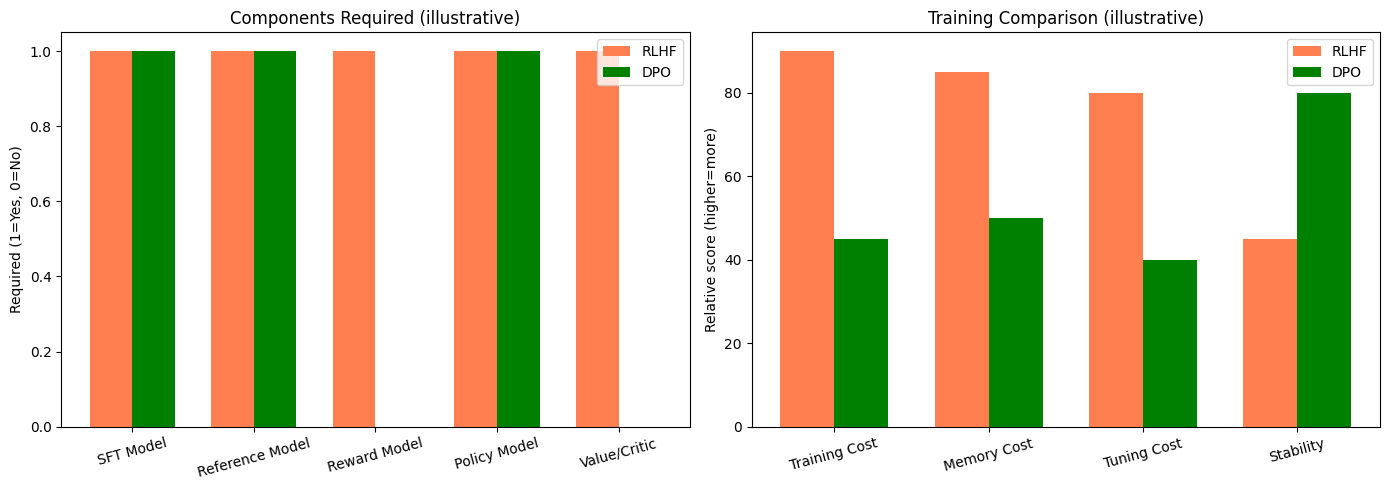

DPO 更简单、更稳定，但 RLHF 在某些场景仍有优势（示意/模拟）


In [6]:
# 可视化 RLHF vs DPO 的复杂度（示意）
comparison = {
    'Components': ['SFT Model', 'Reference Model', 'Reward Model', 'Policy Model', 'Value/Critic'],
    'RLHF': [1, 1, 1, 1, 1],
    'DPO': [1, 1, 0, 1, 0],
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 组件数量
x = np.arange(len(comparison['Components']))
width = 0.35
axes[0].bar(x - width/2, comparison['RLHF'], width, label='RLHF', color='coral')
axes[0].bar(x + width/2, comparison['DPO'], width, label='DPO', color='green')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison['Components'], rotation=15)
axes[0].set_ylabel('Required (1=Yes, 0=No)')
axes[0].set_title('Components Required (illustrative)')
axes[0].legend()

# 训练对比（成本与稳定性，越高越多/越稳定）
metrics = ['Training Cost', 'Memory Cost', 'Tuning Cost', 'Stability']
rlhf_scores = [90, 85, 80, 45]
dpo_scores = [45, 50, 40, 80]

x = np.arange(len(metrics))
axes[1].bar(x - width/2, rlhf_scores, width, label='RLHF', color='coral')
axes[1].bar(x + width/2, dpo_scores, width, label='DPO', color='green')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics, rotation=15)
axes[1].set_ylabel('Relative score (higher=more)')
axes[1].set_title('Training Comparison (illustrative)')
axes[1].legend()

plt.tight_layout()
plt.show()

print("DPO 更简单、更稳定，但 RLHF 在某些场景仍有优势（示意/模拟）")


---

## 本章总结

1. **RLHF 三阶段**
   - SFT → Reward Model → PPO
   - 每个阶段都有特定的训练目标

2. **Reward Model**
   - 学习人类偏好
   - 用 Bradley-Terry loss 训练

3. **PPO**
   - 策略梯度 + Clipping
   - 保持训练稳定性

4. **RLHF vs DPO**
   - RLHF 更复杂但更灵活
   - DPO 更简单更稳定

### 何时使用 RLHF？

- 需要在线学习时
- 奖励函数复杂时
- 需要更精细控制时

In [7]:
# 练习空间

